In [56]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
subject = "EC152"

model1 = "baseline"
model2 = "syllable"

output_csv = "all_scores.csv"

In [58]:
model1_scores = pd.read_csv(f"outputs/encoders/{model1}/{subject}/scores.csv")
model2_scores = pd.read_csv(f"outputs/encoders/{model2}/{subject}/scores.csv")

In [59]:
model1_scores

,fold,output_dim,score,output_name
0,0,0,-0.000439,G1
1,1,0,0.000374,G1
2,2,0,-0.002052,G1
3,0,1,0.002638,G2
4,1,1,0.003156,G2
...,...,...,...,...
763,1,254,-0.002371,G255
764,2,254,0.001496,G255
765,0,255,-0.003878,G256
766,1,255,-0.003740,G256


In [89]:
# plot as grid
grid_num_rows, grid_num_cols = 16, 16
assert len(model1_scores.output_dim.unique()) == grid_num_rows * grid_num_cols
def output_dim_to_grid_coords(output_dim):
    return grid_num_cols - output_dim // grid_num_cols - 1, grid_num_rows - output_dim % grid_num_rows - 1

<Axes: >

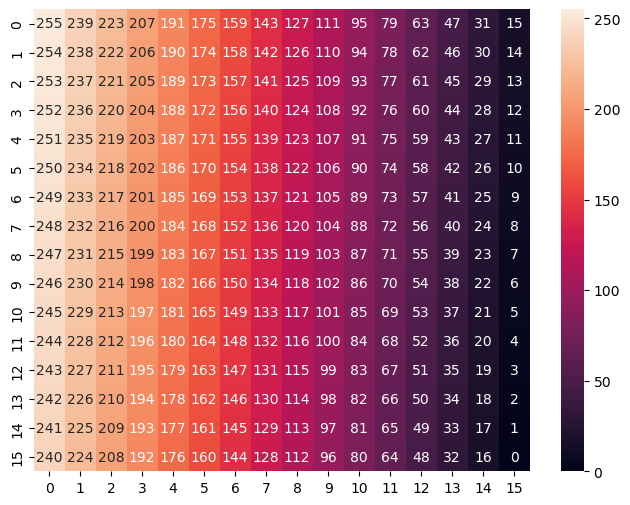

In [61]:
# Sanity check: plot electrode IDs in grid form. Cross-check this with recon
electrode_grid = np.zeros((grid_num_rows, grid_num_cols)) * np.nan
for i in range(256):
    x, y = output_dim_to_grid_coords(i)
    electrode_grid[y, x] = i

f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(electrode_grid, annot=True, fmt=".0f")

## Visualize contrast as heatmap

In [88]:
all_scores = pd.concat([model1_scores, model2_scores], names=["model"], keys=[model1, model2])
all_scores.to_csv(output_csv)
all_scores

fold  output_dim     score output_name
model                                               
baseline 0       0           0 -0.000439          G1
         1       1           0  0.000374          G1
         2       2           0 -0.002052          G1
         3       0           1  0.002638          G2
         4       1           1  0.003156          G2
...            ...         ...       ...         ...
syllable 763     1         254 -0.002381        G255
         764     2         254  0.001492        G255
         765     0         255 -0.003881        G256
         766     1         255 -0.003746        G256
         767     2         255 -0.005243        G256

[1536 rows x 4 columns]

In [62]:
scores_grid = np.zeros((2, grid_num_rows, grid_num_cols)) * np.nan

for i, scores in enumerate([model1_scores, model2_scores]):
    for output_dim, scores_rows in scores.groupby("output_dim"):
        x, y = output_dim_to_grid_coords(output_dim)

        scores_grid[i, y, x] = scores_rows.score.mean()

In [80]:
scores_diff_grid = np.zeros((grid_num_rows, grid_num_cols)) * np.nan

for output_dim, scores_rows in all_scores.groupby("output_dim"):
    x, y = output_dim_to_grid_coords(output_dim)

    comparison_for_dim = scores_rows.reset_index().pivot(index="fold", columns="model", values="score")
    scores_diff_grid[y, x] = (comparison_for_dim[model2] - comparison_for_dim[model1]).mean()

<Axes: >

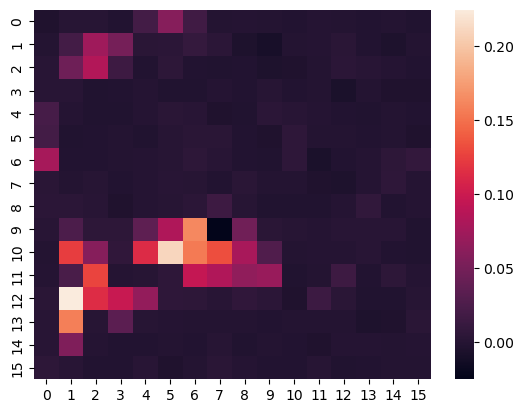

In [63]:
sns.heatmap(scores_grid[0])

<Axes: >

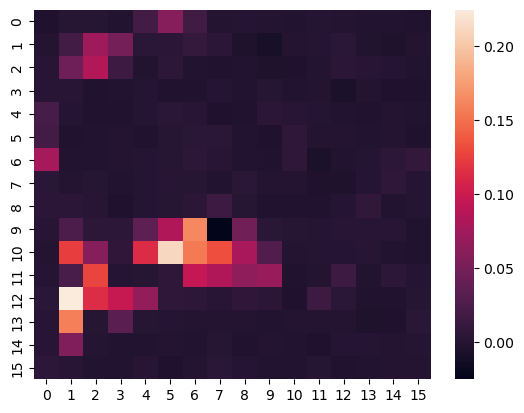

In [64]:
sns.heatmap(scores_grid[1])

[]

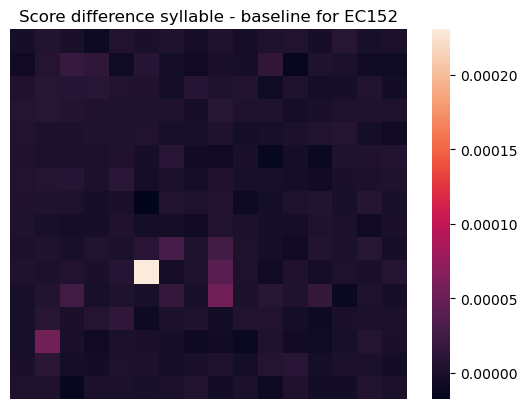

In [81]:
ax = sns.heatmap(scores_diff_grid)
ax.set_title(f"Score difference {model2} - {model1} for {subject}")
ax.set_xticks([])
ax.set_yticks([])

## Quantitative

In [66]:
score_diff = model2_scores.groupby("output_dim").score.mean() - model1_scores.groupby("output_dim").score.mean()

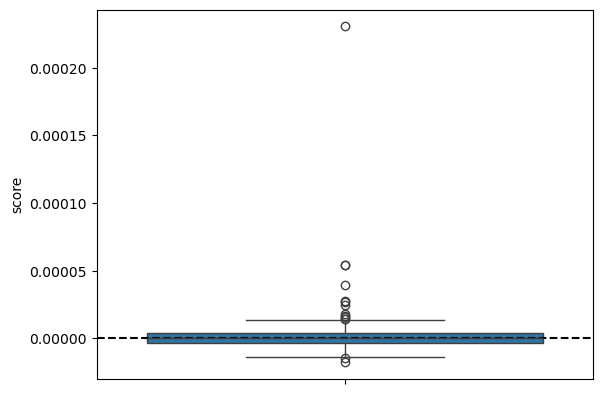

In [67]:
ax = sns.boxplot(score_diff)
ax.axhline(0, color="k", linestyle="--")

### Within-fold difference

In [68]:
model1_prediff = model1_scores.set_index(["output_dim", "fold"]).score.sort_index()
model2_prediff = model2_scores.set_index(["output_dim", "fold"]).score.sort_index()
fold_score_diff = model2_prediff - model1_prediff
fold_score_diff

output_dim  fold
0           0       0.000002
            1       0.000003
            2      -0.000003
1           0      -0.000005
            1      -0.000003
                      ...   
254         1      -0.000010
            2      -0.000004
255         0      -0.000004
            1      -0.000006
            2       0.000001
Name: score, Length: 768, dtype: float64

<Axes: ylabel='score'>

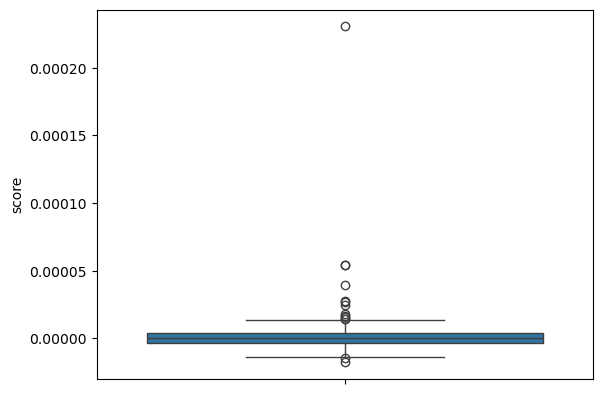

In [69]:
sns.boxplot(fold_score_diff.groupby("output_dim").mean())